# Analysis 3 Ver2


In this notebook we use the super reduced dst form the AB reducing process, in order to have fast energy reoslution analysis, with the advantage of being able to access to the isolated and non isolated hit without running the splitter again. 

In [2]:
import os
import logging
import warnings

import numpy  as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.special import erf

from scipy.stats import linregress

from invisible_cities.io.dst_io               import load_dst, load_dsts
from krcal.NB_utils.fit_energy_functions      import fit_energy
from krcal.NB_utils.plt_energy_functions      import plot_fit_energy, print_fit_energy

from invisible_cities.reco import corrections

from invisible_cities.reco.corrections        import read_maps


In [3]:
def in_range(series, min_val, max_val):
    """Checks if values in a pandas Series are within a [min, max) range."""
    return (series >= min_val) & (series < max_val)


def gaus_with_linear_bg(x, amplitude, mu, sigma, slope, intercept):
    """A Gaussian peak with a sloped, linear background."""
    sigma = max(abs(sigma), 1e-9) # Failsafe for sigma
    gauss_part = amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))
    linear_part = slope * x + intercept
    return gauss_part + linear_part

def fit_peak_crystal_ball(data, mu_guess, fit_range, bins='auto'):
    """Fits a Crystal Ball + linear background to a peak."""
    y, bin_edges = np.histogram(data, bins=bins, range=fit_range)
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    if np.sum(y) < 50: return None, None, (x, y)

    # Smart guesses
    slope_guess = (np.mean(y[-5:]) - np.mean(y[:5])) / (x[-1] - x[0])
    intercept_guess = np.mean(y[:5]) - slope_guess * x[0]
    amplitude_guess = y.max() - (slope_guess * mu_guess + intercept_guess)
    sigma_guess = (fit_range[1] - fit_range[0]) / 10
    
    # Crystal ball specific guesses (alpha controls where tail starts, n controls shape)
    alpha_guess = 1.0 
    n_guess = 2.0
    
    p0 = [amplitude_guess, mu_guess, sigma_guess, alpha_guess, n_guess, slope_guess, intercept_guess]

    try:
        popt, pcov = curve_fit(crystal_ball_with_linear_bg, x, y, p0=p0, sigma=np.sqrt(np.maximum(y, 1)))
        return popt, pcov, (x, y)
    except (RuntimeError, ValueError) as e:
        print(f"  - Fit failed for peak near {mu_guess:.1f}. Reason: {e}")
        return None, None, (x, y)
    

def crystal_ball_with_linear_bg(x, amplitude, mu, sigma, alpha, n, slope, intercept):
    """Crystal Ball function with a linear background."""
    # Failsafes for stability
    sigma = max(abs(sigma), 1e-9)
    n = max(n, 1e-9)
    alpha = max(alpha, 1e-9)

    t = (x - mu) / sigma
    
    # Gaussian part
    gauss = amplitude * np.exp(-0.5 * t**2)
    
    # Power-law tail part
    A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
    B = n / abs(alpha) - abs(alpha)
    tail = amplitude * A * (B - t)**(-n)
    
    # Combine using masks
    cb_shape = np.where(t > -alpha, gauss, tail)
    
    return cb_shape + (slope * x + intercept)

In [18]:
run_ids = [15589, 15590, 15591, 15593, 15594, 15596]
#run_ids = [15591]
base_path = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE"

kdst_key = "FinalFeatures"
all_dfs = []

for run_id in run_ids:
    kdst_input_glob = f"{base_path}/{run_id}/sophronia/final_dst/*final_features_with_TE_v3.h5"
    kdst_files = sorted(glob.glob(kdst_input_glob))
    if not kdst_files:
        raise FileNotFoundError(f"No kDST files found at: {kdst_input_glob}")
    
    print(f"Found {len(kdst_files)} files for run {run_id}")
    all_dfs.extend(pd.read_hdf(path, key=kdst_key) for path in kdst_files)

full_fil_df = pd.concat(all_dfs, ignore_index=True)


print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")
full_fil_df = full_fil_df[full_fil_df.E_final > 0]
full_fil_df = full_fil_df[full_fil_df.DT > 0]
full_fil_df = full_fil_df[in_range(full_fil_df.Rmax, 0, 450)]
full_fil_df = full_fil_df[
    in_range(full_fil_df.Zmin, 20, 1184.185) & 
    in_range(full_fil_df.Zmax, 20, 1184.185)
]

print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")

Found 7 files for run 15589
Found 7 files for run 15590
Found 7 files for run 15591
Found 7 files for run 15593
Found 7 files for run 15594
Found 7 files for run 15596
Loaded 1663160 unique events from kDSTs.
Loaded 1081441 unique events from kDSTs.


In [11]:
KNOWN_PEAKS_PES = {
    "511 keV":   {'real_MeV': 0.511,  'guess': 1.05e5,  'range': (1e5, 1.09e5)},
    "583 keV":   {'real_MeV': 0.583,  'guess': 1.2e5,  'range': (1.14e5, 1.24e5)},
    "727 keV":   {'real_MeV': 0.727,  'guess': 1.5e5,  'range': (1.41e5, 1.56e5)},
    "860 keV":   {'real_MeV': 0.860,  'guess': 1.77e5,  'range': (1.71e5, 1.84e5)},
    "DE Peak":   {'real_MeV': 1.592,  'guess': 3.3e5,  'range': (3.23e5, 3.37e5)},
    "Tl Peak":   {'real_MeV': 2.615,  'guess': 5.42e5,  'range': (5.34e5, 5.54e5)}
    # Add other peaks as needed
}

In [21]:
def calibrate_pes_to_MeV_and_get_resolution(
    event_energies_df: pd.DataFrame, # Expects 'E_corr' in pes
    workflow_name: str,
    known_peaks_pes: dict # Dictionary with guesses/ranges in pes
):
    """
    A full pipeline that:
    1. Fits peaks in the uncalibrated 'pes' spectrum.
    2. Determines the linear pes -> MeV calibration.
    3. Applies the calibration.
    4. Re-fits the peaks in the calibrated MeV spectrum to find the resolution.
    """
    print(f"\n{'='*20} Running pes->MeV Calibration for: {workflow_name} {'='*20}")
    
    initial_energies_pes = event_energies_df['E_final']
    
    # --- Stage 1: Initial Fits in PES ---
    print("\nStage 1: Fitting uncalibrated peaks to find positions in PES...")
    initial_fit_results = []
    fig_init, axes_init = plt.subplots(int(np.ceil(len(known_peaks_pes)/2)), 2, figsize=(16, 5 * np.ceil(len(known_peaks_pes)/2)))
    axes_init = axes_init.flatten()
    fig_init.suptitle(f'Initial Peak Fits in PES ({workflow_name})', fontsize=16)

    for i, (peak_name, props) in enumerate(known_peaks_pes.items()):
        ax = axes_init[i]
        popt, pcov, hist_data = fit_peak_crystal_ball(initial_energies_pes, props['guess'], props['range'], bins=props.get('bins', 'auto'))
        
        ax.step(hist_data[0], hist_data[1], where='mid', label='Data')
        if popt is not None:
            fit_x = np.linspace(props['range'][0], props['range'][1], 300)
            ax.plot(fit_x, crystal_ball_with_linear_bg(fit_x, *popt), 'r-', label='Fit')
            mu, mu_err = popt[1], np.sqrt(pcov[1, 1])
            initial_fit_results.append({'name': peak_name, 'real_E_MeV': props['real_MeV'], 'measured_E_pes': mu, 'measured_E_err_pes': mu_err})
            ax.text(0.05, 0.95, f'μ = {mu:.1f} ± {mu_err:.1f} pes', transform=ax.transAxes, va='top')
        ax.set_title(peak_name); ax.set_xlabel('Measured Energy (pes)'); ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    
    # --- Stage 2: Linear Calibration Fit (MeV vs. pes) ---
    fit_df = pd.DataFrame(initial_fit_results)
    if len(fit_df) < 2:
        print("Not enough successful fits to perform calibration. Aborting."); return None
    
    # Fit: Real_MeV = m * Measured_pes + n
    calib_fit = linregress(fit_df['measured_E_pes'], fit_df['real_E_MeV'])
    m, n = calib_fit.slope, calib_fit.intercept
    print(f"\nStage 2: Calibration found: E_MeV = {m:.2e} * E_pes + {n:.4f}")

    fig_calib, ax_calib = plt.subplots(figsize=(8, 6))
    ax_calib.errorbar(fit_df['measured_E_pes'], fit_df['real_E_MeV'], xerr=fit_df['measured_E_err_pes'], fmt='o', capsize=3, label='Fitted Peaks')
    x_fit = np.array([0, fit_df['measured_E_pes'].max() * 1.1]); y_fit = m * x_fit + n
    ax_calib.plot(x_fit, y_fit, 'r--', label=f'Linear Fit: MeV/pe = {m:.2e}'); ax_calib.set_title('pes to MeV Calibration'); ax_calib.set_xlabel('Measured Peak Energy (pes)'); ax_calib.set_ylabel('Real Peak Energy (MeV)'); ax_calib.legend(); ax_calib.grid(True)
    plt.show()

    # --- Stage 3: Apply Calibration ---
    print("\nStage 3: Applying calibration to convert spectrum to MeV...")
    calibrated_energies_MeV = m * initial_energies_pes + n
    
    # --- Stage 4: Final Resolution Fits in MeV ---
    print("\nStage 4: Calculating final energy resolution...")
    final_resolution_results = []
    fig_final, axes_final = plt.subplots(int(np.ceil(len(known_peaks_pes)/2)), 2, figsize=(16, 5 * np.ceil(len(known_peaks_pes)/2)))
    axes_final = axes_final.flatten()
    fig_final.suptitle(f'Final Resolution Fits in MeV ({workflow_name})', fontsize=16)

    for i, (peak_name, props) in enumerate(known_peaks_pes.items()):
        ax = axes_final[i]
        real_E = props['real_MeV']
        # Define fit range in calibrated MeV units
        calib_range = (real_E - 0.05, real_E + 0.05)
        popt, pcov, hist_data = fit_peak_crystal_ball(calibrated_energies_MeV, real_E, calib_range, bins=props.get('bins', 'auto'))
        
        ax.step(hist_data[0], hist_data[1], where='mid', label='Data')
        if popt is not None:
            fit_x = np.linspace(calib_range[0], calib_range[1], 300)
            ax.plot(fit_x, crystal_ball_with_linear_bg(fit_x, *popt), 'r-', label='Fit')
            mu, sigma = popt[1], abs(popt[2])
            mu_err, sigma_err = np.sqrt(pcov[1, 1]), np.sqrt(pcov[2, 2])
            resolution = 2.355 * sigma / mu * 100
            res_err = resolution * np.sqrt((sigma_err/sigma)**2 + (mu_err/mu)**2) if sigma > 0 else np.nan
            final_resolution_results.append({'peak': peak_name, 'resolution_fwhm_percent': resolution, 'resolution_error': res_err})
            ax.text(0.05, 0.95, f'μ = {mu:.4f} ± {mu_err:.4f} MeV\nR(%) = {resolution:.2f} ± {res_err:.2f}', transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', alpha=0.5))
        ax.set_title(peak_name); ax.set_xlabel('Calibrated Energy (MeV)'); ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    
    return pd.DataFrame(final_resolution_results)


==================== Running pes->MeV Calibration for: Workflow D ====================

Stage 1: Fitting uncalibrated peaks to find positions in PES...


/tmp/villamil/ipykernel_3788321/4120482186.py:55: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/tmp/villamil/ipykernel_3788321/4120482186.py:53: RuntimeWarning: overflow encountered in double_scalars
  A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
/tmp/villamil/ipykernel_3788321/4120482186.py:55: RuntimeWarning: invalid value encountered in multiply
  tail = amplitude * A * (B - t)**(-n)
/tmp/villamil/ipykernel_3788321/4120482186.py:55: RuntimeWarning: overflow encountered in double_scalars
  tail = amplitude * A * (B - t)**(-n)
/tmp/villamil/ipykernel_3788321/4120482186.py:55: RuntimeWarning: divide by zero encountered in power
  tail = amplitude * A * (B - t)**(-n)


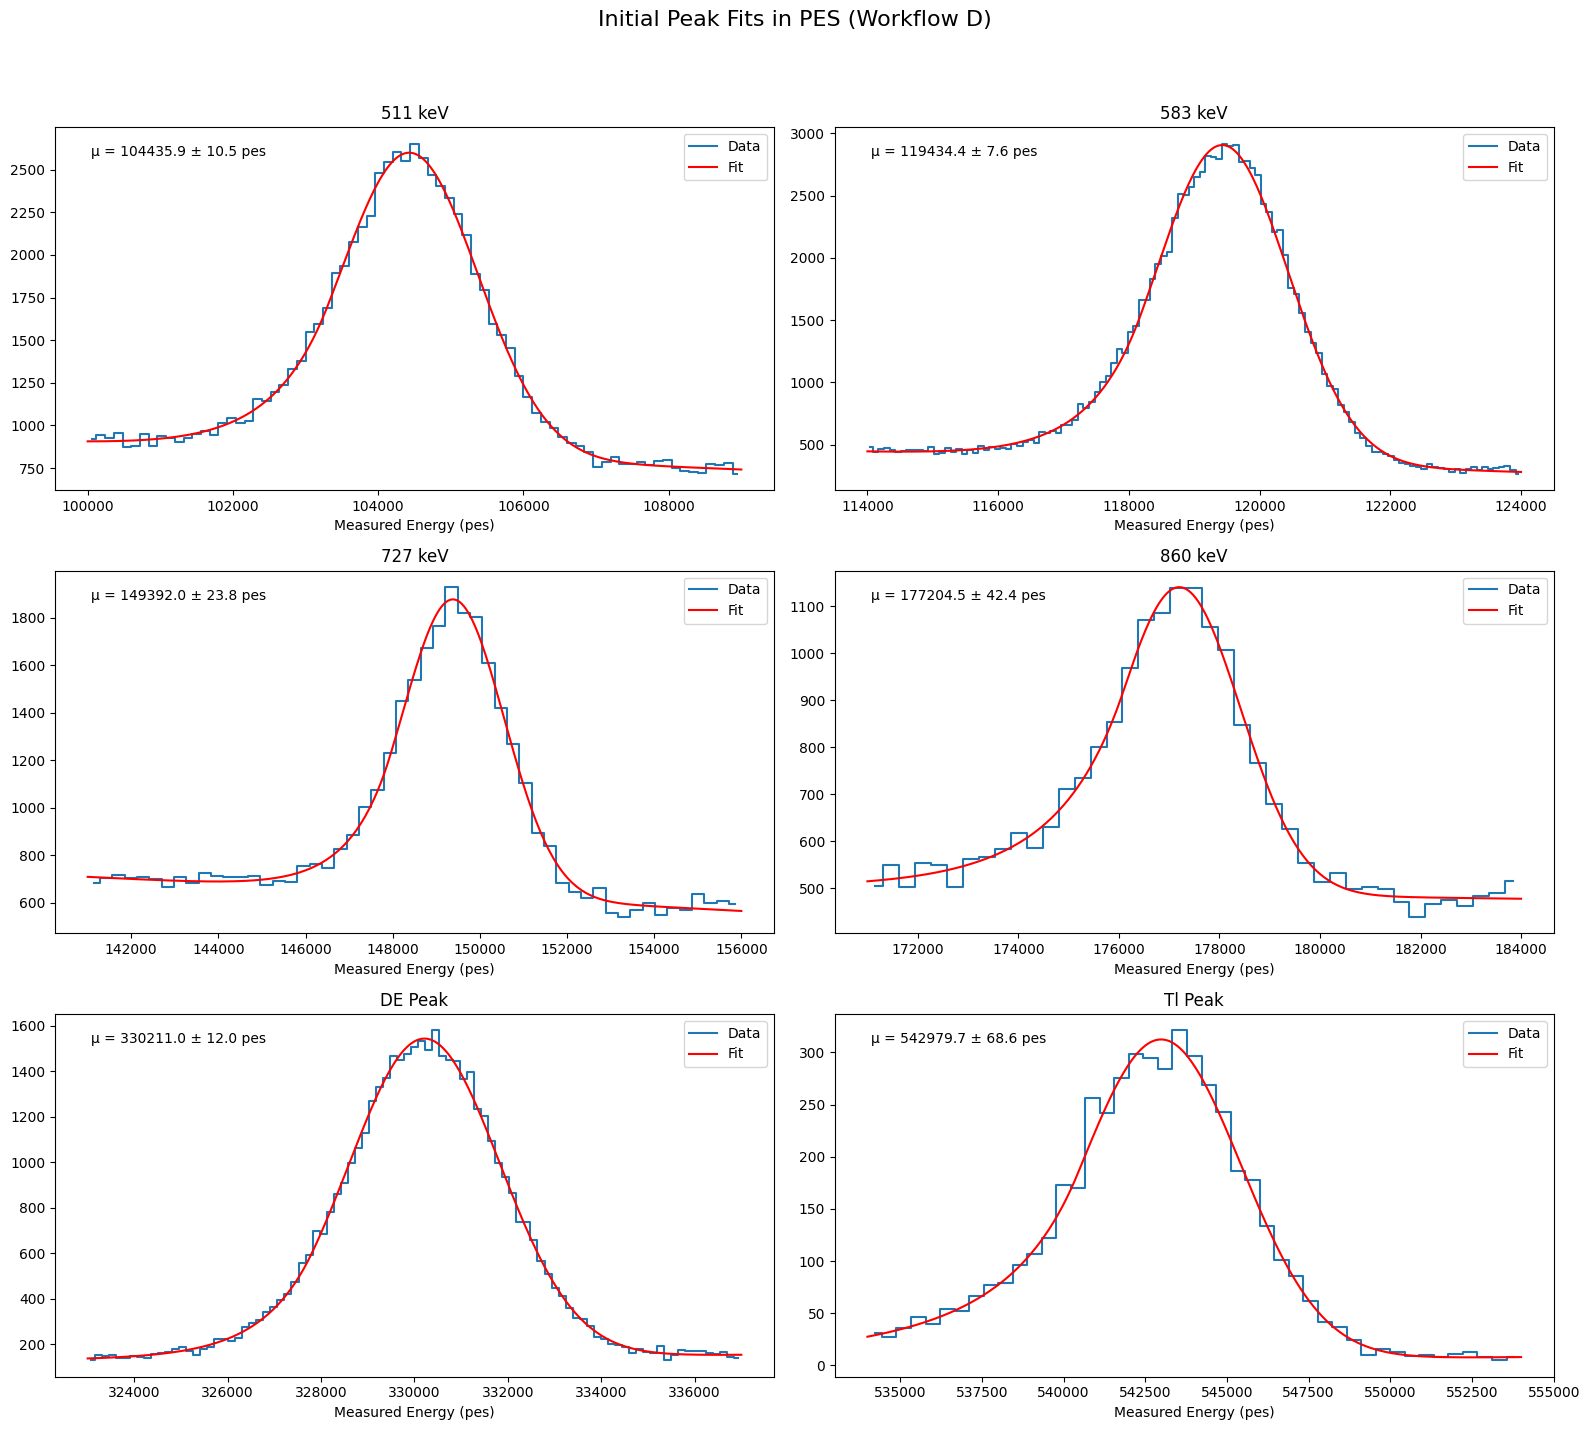


Stage 2: Calibration found: E_MeV = 4.80e-06 * E_pes + 0.0100


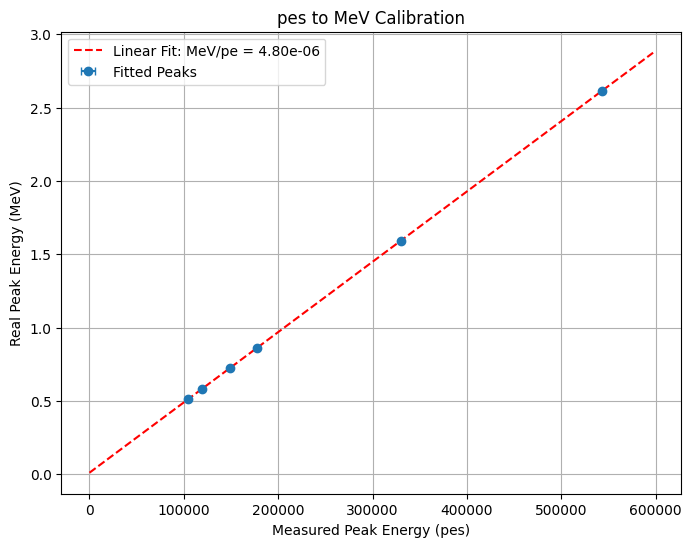


Stage 3: Applying calibration to convert spectrum to MeV...

Stage 4: Calculating final energy resolution...


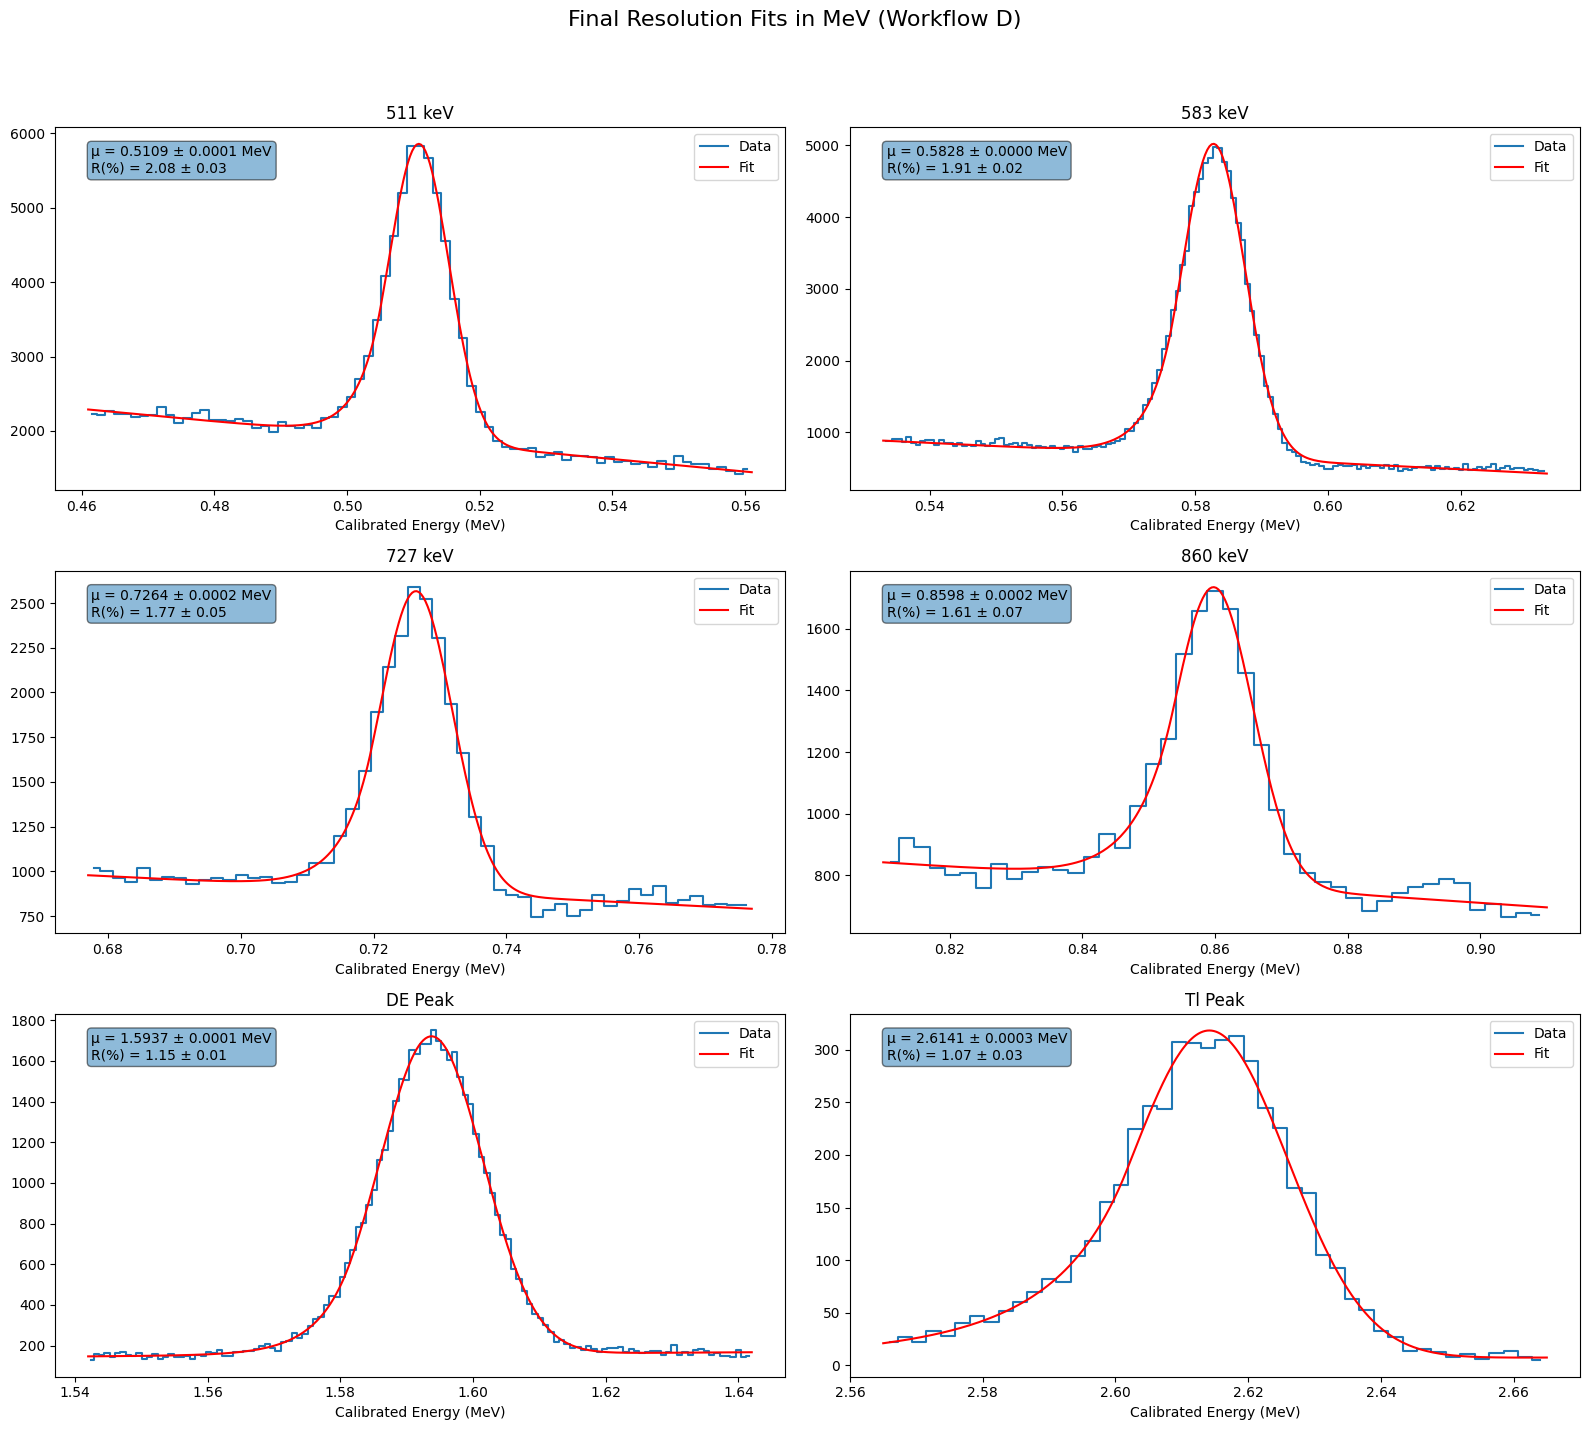


--- Final Resolution Summary ---
      peak  resolution_fwhm_percent  resolution_error
0  511 keV                 2.080397          0.025935
1  583 keV                 1.909307          0.019132
2  727 keV                 1.772840          0.052614
3  860 keV                 1.611796          0.072235
4  DE Peak                 1.152148          0.008303
5  Tl Peak                 1.066352          0.032507


In [22]:
resolution_table = calibrate_pes_to_MeV_and_get_resolution(
     event_energies_df=full_fil_df,
     workflow_name="Workflow D",
     known_peaks_pes=KNOWN_PEAKS_PES
 )

print("\n--- Final Resolution Summary ---")
print(resolution_table)

Lets try now but with the dataset that hast the time evolution correction implemented

In [7]:
#run_ids = [15589, 15590, 15591, 15593, 15594, 15596]
run_ids = [15589]
base_path = "/lustre/ific.uv.es/prj/gl/neutrinos/users/villamil/kr_next100/HE"

kdst_key = "FinalFeatures"
all_dfs = []

for run_id in run_ids:
    kdst_input_glob = f"{base_path}/{run_id}/sophronia/final_dst/*final_features_with_TE.h5"
    kdst_files = sorted(glob.glob(kdst_input_glob))
    if not kdst_files:
        raise FileNotFoundError(f"No kDST files found at: {kdst_input_glob}")
    
    print(f"Found {len(kdst_files)} files for run {run_id}")
    all_dfs.extend(pd.read_hdf(path, key=kdst_key) for path in kdst_files)

full_fil_df = pd.concat(all_dfs, ignore_index=True)


print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")
full_fil_df = full_fil_df[full_fil_df.E_final > 0]
full_fil_df = full_fil_df[full_fil_df.DT > 0]
full_fil_df = full_fil_df[in_range(full_fil_df.Rmax, 0, 450)]
full_fil_df = full_fil_df[
    in_range(full_fil_df.Zmin, 20, 1184.185) & 
    in_range(full_fil_df.Zmax, 20, 1184.185)
]

print(f"Loaded {full_fil_df['event'].nunique()} unique events from kDSTs.")

Found 7 files for run 15589
Loaded 346353 unique events from kDSTs.
Loaded 206055 unique events from kDSTs.



==================== Running pes->MeV Calibration for: Workflow D ====================

Stage 1: Fitting uncalibrated peaks to find positions in PES...


/tmp/villamil/ipykernel_2046966/4120482186.py:55: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/tmp/villamil/ipykernel_2046966/4120482186.py:53: RuntimeWarning: overflow encountered in double_scalars
  A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
/tmp/villamil/ipykernel_2046966/4120482186.py:55: RuntimeWarning: invalid value encountered in multiply
  tail = amplitude * A * (B - t)**(-n)
/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/sw/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/villamil/ipykernel_2046966/4120482186.py:55: RuntimeWarning: divide by zero encountered in power
  tail = amplitude * A * (B - t)**(-n)


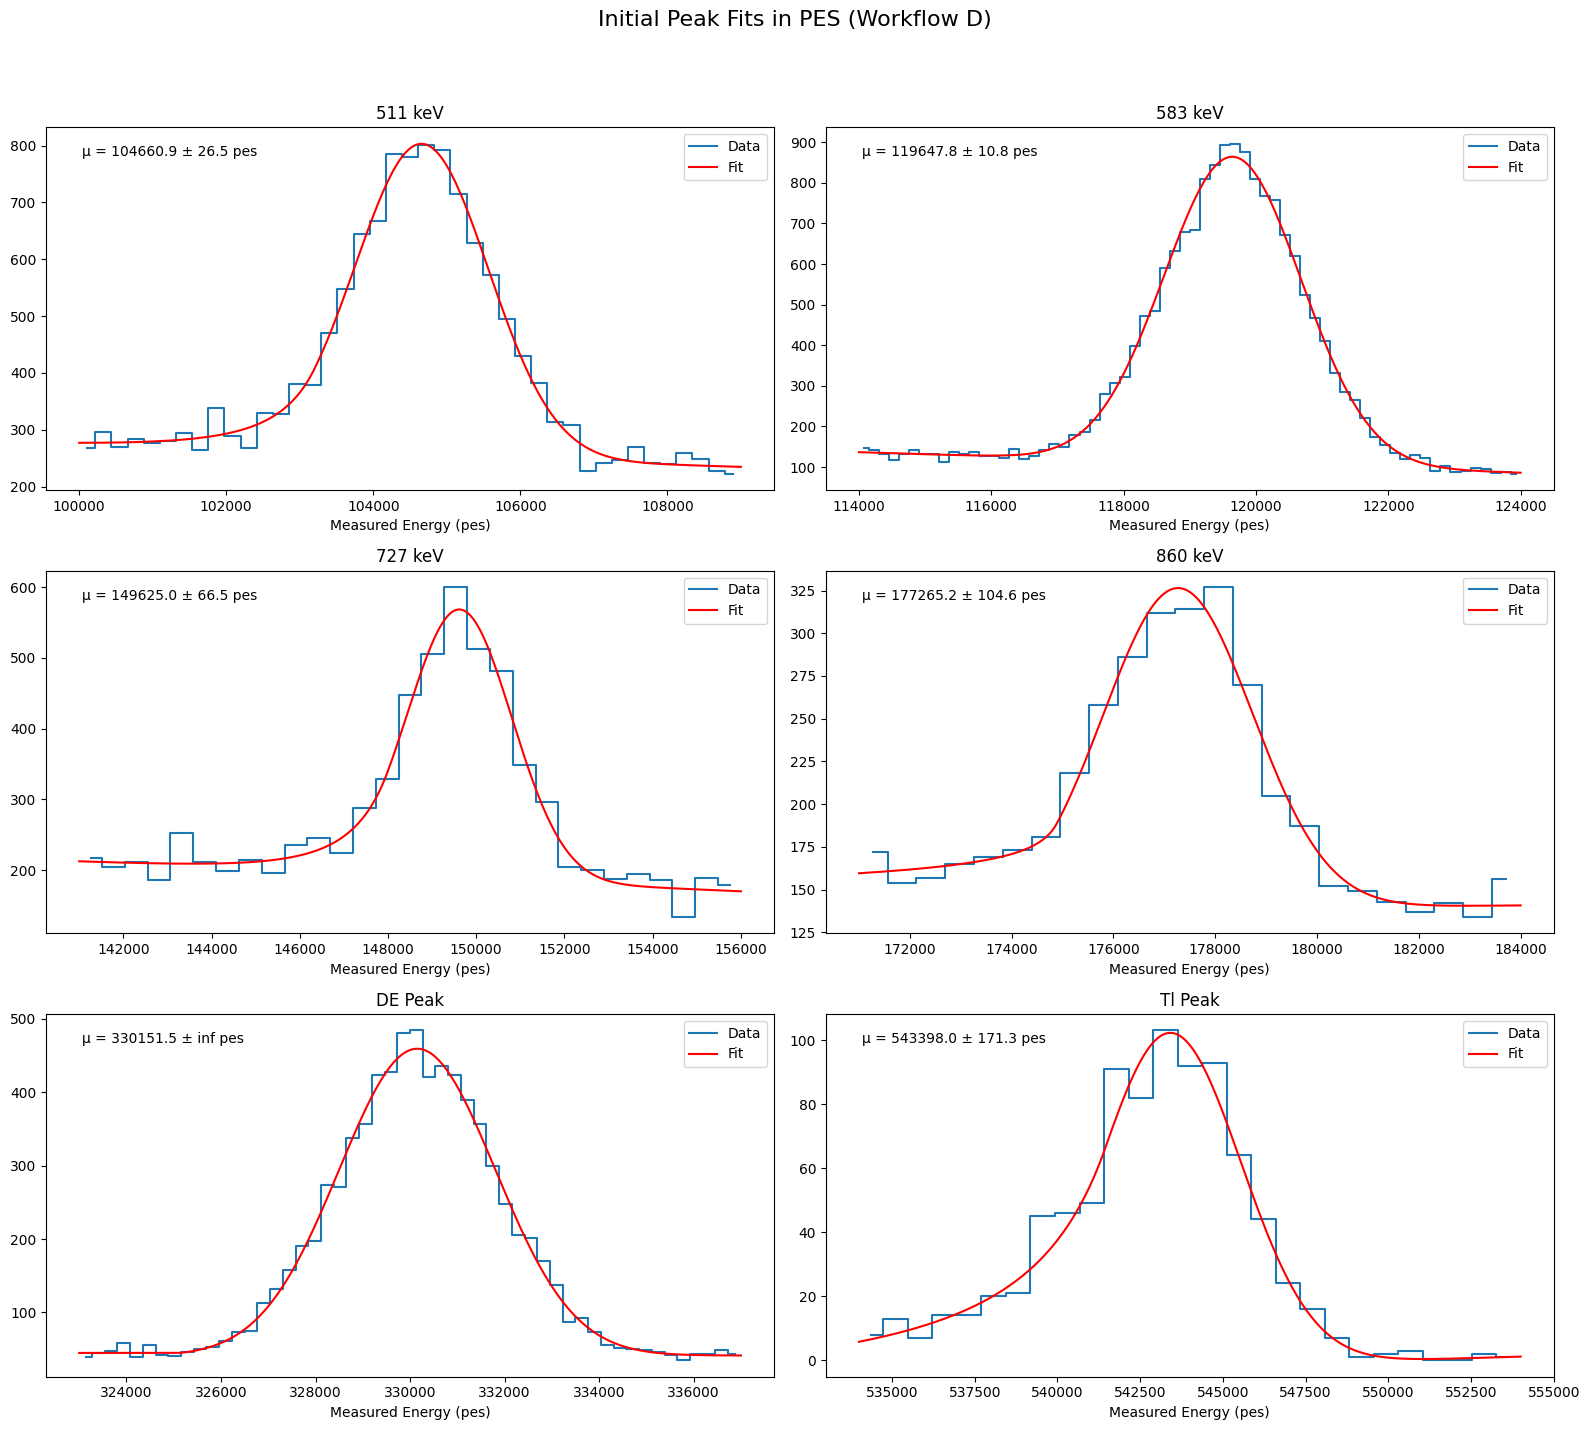


Stage 2: Calibration found: E_MeV = 4.79e-06 * E_pes + 0.0095


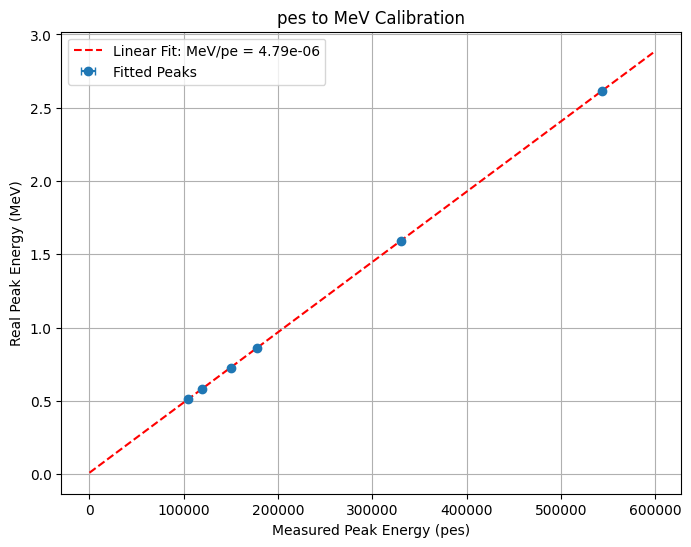


Stage 3: Applying calibration to convert spectrum to MeV...

Stage 4: Calculating final energy resolution...


/tmp/villamil/ipykernel_2046966/4120482186.py:55: RuntimeWarning: overflow encountered in double_scalars
  tail = amplitude * A * (B - t)**(-n)


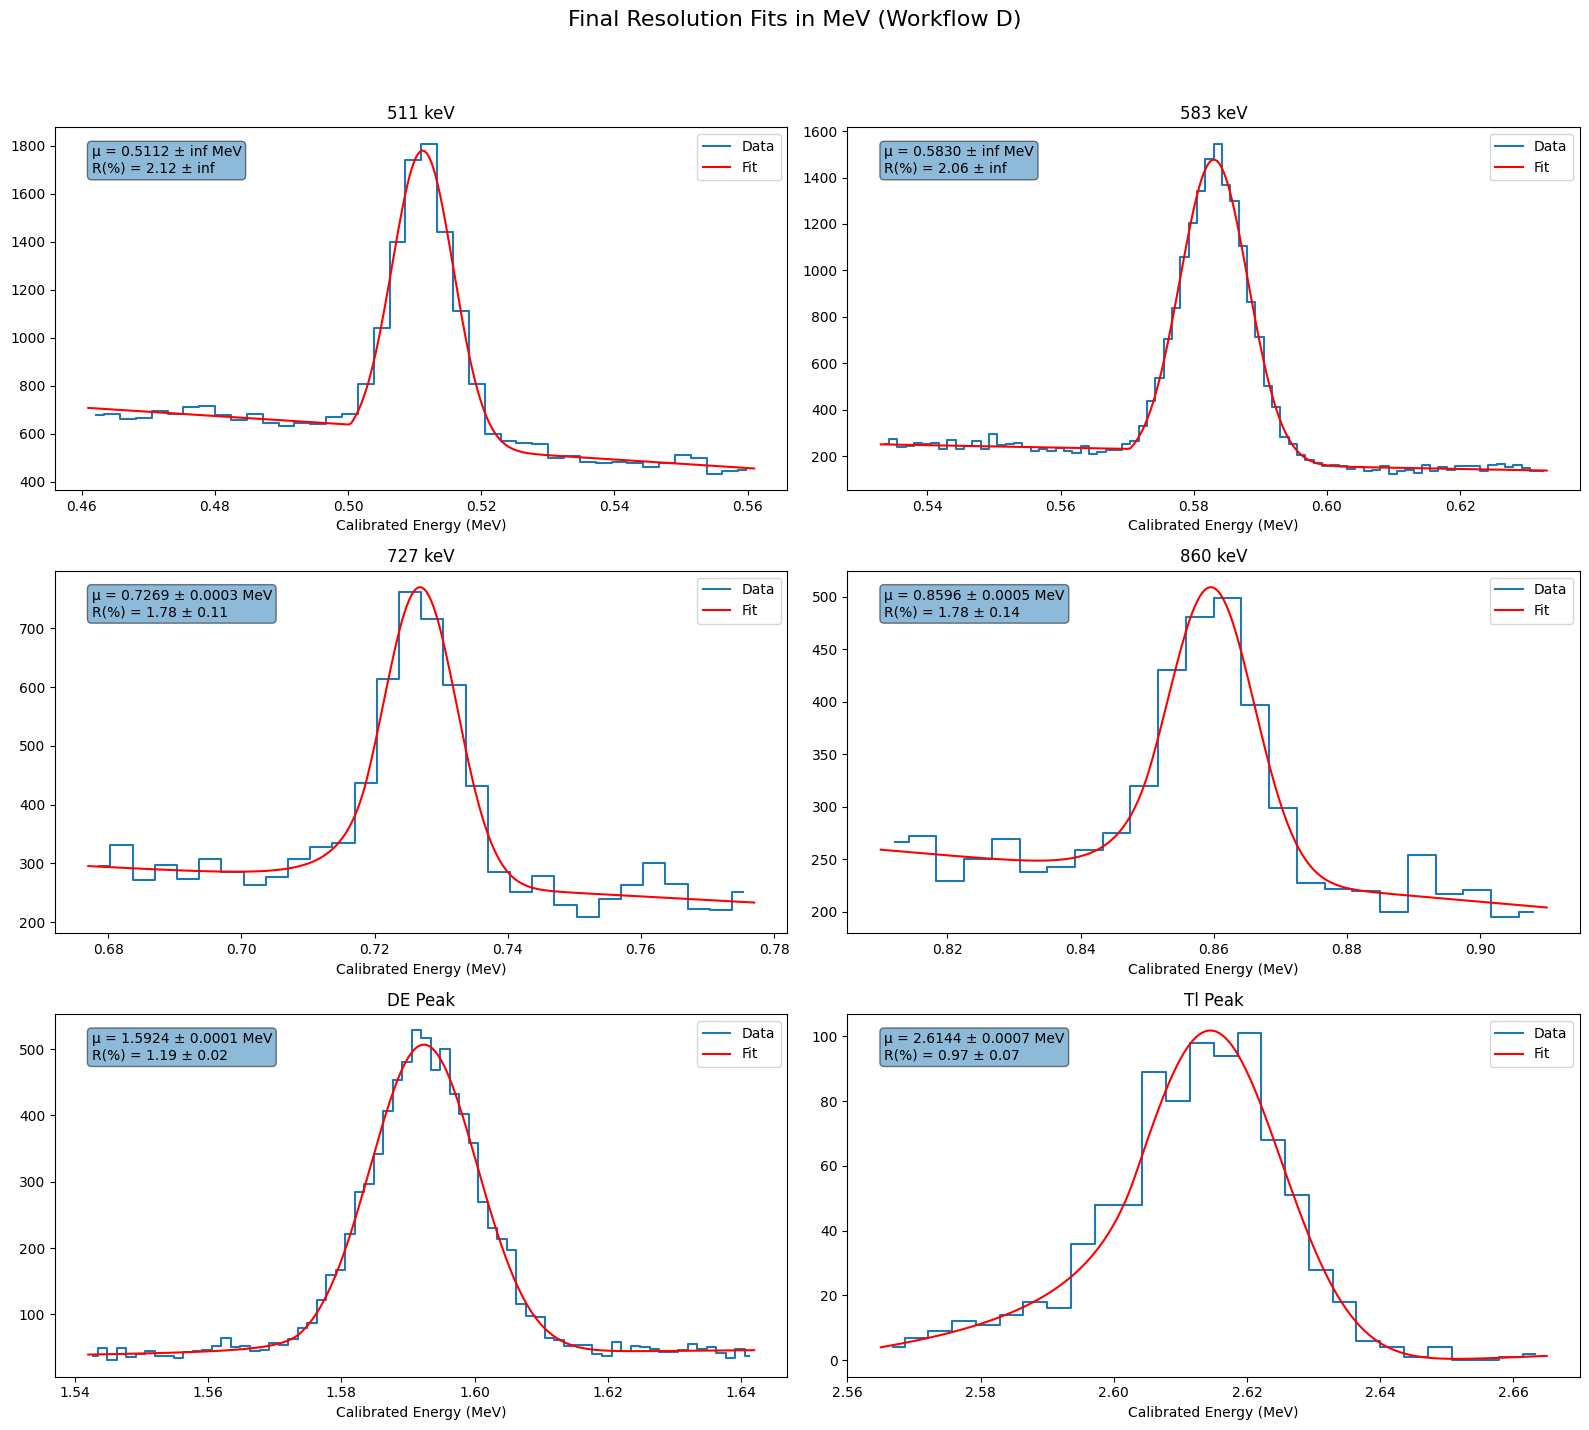


--- Final Resolution Summary ---
      peak  resolution_fwhm_percent  resolution_error
0  511 keV                 2.123982               inf
1  583 keV                 2.057922               inf
2  727 keV                 1.781818          0.111843
3  860 keV                 1.775279          0.137516
4  DE Peak                 1.185230          0.021564
5  Tl Peak                 0.969549          0.065809


In [30]:
resolution_table = calibrate_pes_to_MeV_and_get_resolution(
     event_energies_df=full_fil_df,
     workflow_name="Workflow D",
     known_peaks_pes=KNOWN_PEAKS_PES
 )

print("\n--- Final Resolution Summary ---")
print(resolution_table)